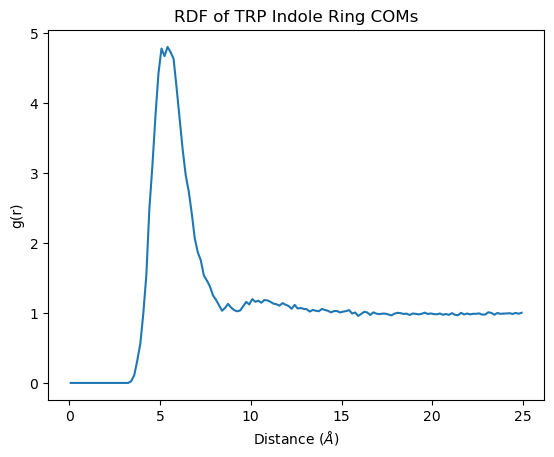

In [1]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array

TPR = "md_0_sim_resp_24trp_500ns.tpr"
XTC = "md_0_sim_resp_24trp_500ns_pbc_center.xtc"
u = mda.Universe(TPR, XTC)
trp = u.select_atoms("resname TRP")

def compute_ring_coms(trp):
    coms = np.array([
        trp.select_atoms(f"resid {res.resid} and name C1 N1 C2 C3 C4 C5 C6 C7 C8").center_of_mass()
        for res in trp.residues
    ])
    return coms


r_min, r_max, nbins = 0.0, 25.0, 150
edges = np.linspace(r_min, r_max, nbins + 1)
N = len(trp.residues)  # Number of TRP residues
hist = np.zeros(nbins, dtype=np.float64)
sum_1_over_V = 0.0


for ts in u.trajectory:
    coms = compute_ring_coms(trp)
    V = ts.volume  # Correct volume for any box type
    # print(V)
    sum_1_over_V += 1.0 / V
    n = len(coms)
    if n < 2:
        continue
    # Compute distances with PBC
    dist_matrix = distance_array(coms, coms, box=ts.dimensions)
    i, j = np.triu_indices(n, k=1)
    dist = dist_matrix[i, j]
    current_hist, _ = np.histogram(dist, bins=edges)
    hist += current_hist
    
    
volume_shells = (4.0 / 3.0) * np.pi * (edges[1:]**3 - edges[:-1]**3)
expected = 0.5 * N * (N - 1) * volume_shells * sum_1_over_V
g_r = np.divide(hist, expected, out=np.zeros_like(hist), where=expected != 0)


r = (edges[:-1] + edges[1:]) / 2.0
plt.figure()
plt.plot(r, g_r)
plt.xlabel(r'Distance ($\AA$)')
plt.ylabel('g(r)')
# plt.axvline(6.5)
plt.title('RDF of TRP Indole Ring COMs')
plt.show()   

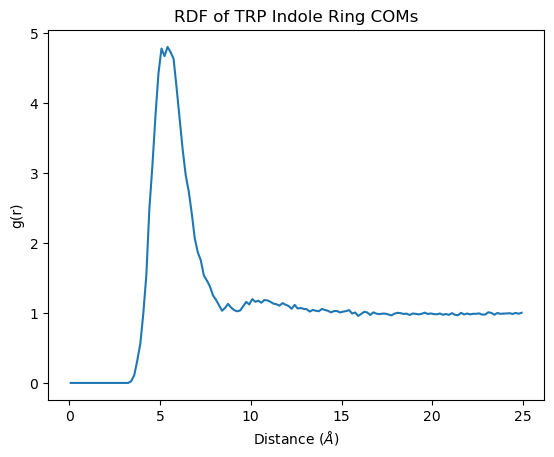

In [2]:
plt.figure()
plt.plot(r, g_r)
plt.xlabel(r'Distance ($\AA$)')
plt.ylabel('g(r)')
# plt.axvline(6.5)
plt.title('RDF of TRP Indole Ring COMs')
plt.show()  

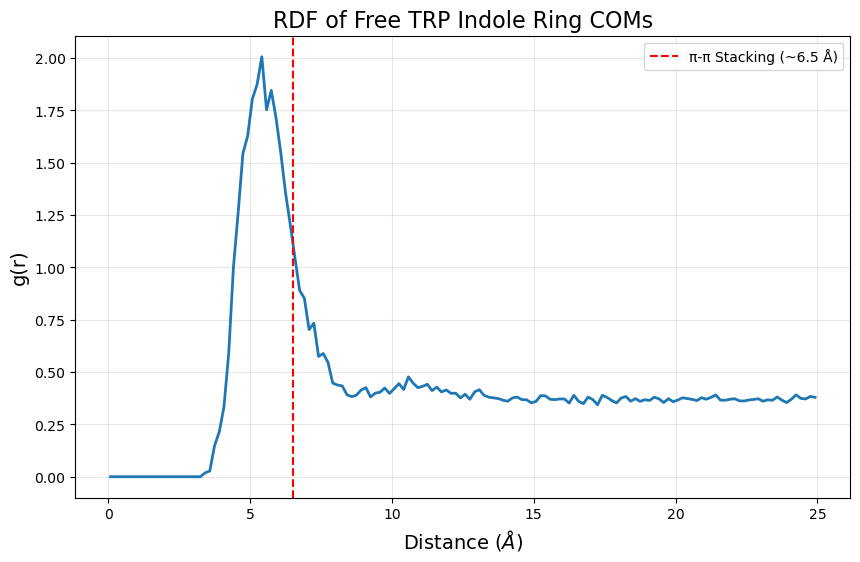

In [3]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array

# Load trajectory and topology
TPR = 'md_0_sim_resp_24trp-1ta_500ns.tpr'
XTC = 'md_0_sim_resp_24trp-1ta_500ns_pbc_center.xtc'
u = mda.Universe(TPR, XTC)

# Select TRP and TA5
trp = u.select_atoms("resname TRP")
ta = u.select_atoms("resname TA5")

# Function to compute COM of indole rings in TRP
def compute_ring_coms(trp):
    return np.array([
        trp.select_atoms(f"resid {res.resid} and name C1 N1 C2 C3 C4 C5 C6 C7 C8").center_of_mass()
        for res in trp.residues
    ])

# Distance between two centers of mass
def compute_distance(pos1, pos2, box_length):
    delta = pos1 - pos2
    delta -= np.round(delta / box_length) * box_length  # Apply PBC correction
    return np.linalg.norm(delta)

# Parameters
cutoff_1 = 15.0  # Cutoff distance to consider a TRP "free"
bins = 150
r_range = (0.0, 25.0)
bin_edges = np.linspace(r_range[0], r_range[1], bins + 1)
bin_centers1 = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_width = bin_edges[1] - bin_edges[0]

# Initialize histogram for RDF
hist = np.zeros(bins)
sum_1_over_V = 0.0

# Process trajectory
for ts in u.trajectory:
    # Compute TRP COMs
    trp_coms = compute_ring_coms(trp)
    
    # Compute TA COMs
    ta_coms = np.array([
        ta.atoms.select_atoms(f"resid {res.resid}").center_of_mass()
        for res in ta.residues
    ])

    # Find TRPs inside the cutoff distance
    inside_trps_idxs = []
    for ta_com in ta_coms:
        distances_to_ta = np.array([compute_distance(trp_com, ta_com, u.dimensions[:3]) for trp_com in trp_coms])
        inside_trps_idxs.append(np.where(distances_to_ta <= cutoff_1)[0])

    # Flatten and get unique TRPs within cutoff
    inside_trps_idxs = np.unique(np.concatenate(inside_trps_idxs)) if inside_trps_idxs else np.array([])

    # Identify free TRPs (those NOT inside the cutoff)
    free_trps = np.delete(np.arange(len(trp_coms)), inside_trps_idxs)

    # Skip if fewer than 2 free TRPs
    if len(free_trps) < 2:
        continue

    # Get coordinates of free TRPs
    free_trp_coms = trp_coms[free_trps]

    # Compute distances between free TRPs
    dist_matrix = distance_array(free_trp_coms, free_trp_coms, box=ts.dimensions)
    i, j = np.triu_indices(len(free_trp_coms), k=1)
    dist = dist_matrix[i, j]

    # Histogram binning
    current_hist, _ = np.histogram(dist, bins=bin_edges)
    hist += current_hist

    # Volume for normalization
    V = ts.volume
    sum_1_over_V += 1.0 / V

# Normalize RDF
N = len(trp.residues)  # Total TRPs
volume_shells = (4.0 / 3.0) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
expected = 0.5 * N * (N - 1) * volume_shells * sum_1_over_V
g_r1 = np.divide(hist, expected, out=np.zeros_like(hist), where=expected != 0)

# Plot RDF
plt.figure(figsize=(10, 6))
plt.plot(bin_centers1, g_r1, linewidth=2)
plt.xlabel(r'Distance ($\AA$)', fontsize=14)
plt.ylabel('g(r)', fontsize=14)
plt.title('RDF of Free TRP Indole Ring COMs', fontsize=16)
plt.axvline(6.5, linestyle="--", color="red", label="π-π Stacking (~6.5 Å)")
plt.legend()
plt.grid(True, alpha=0.3)
# plt.savefig('free_trp_rdf.png', dpi=300)
plt.show()


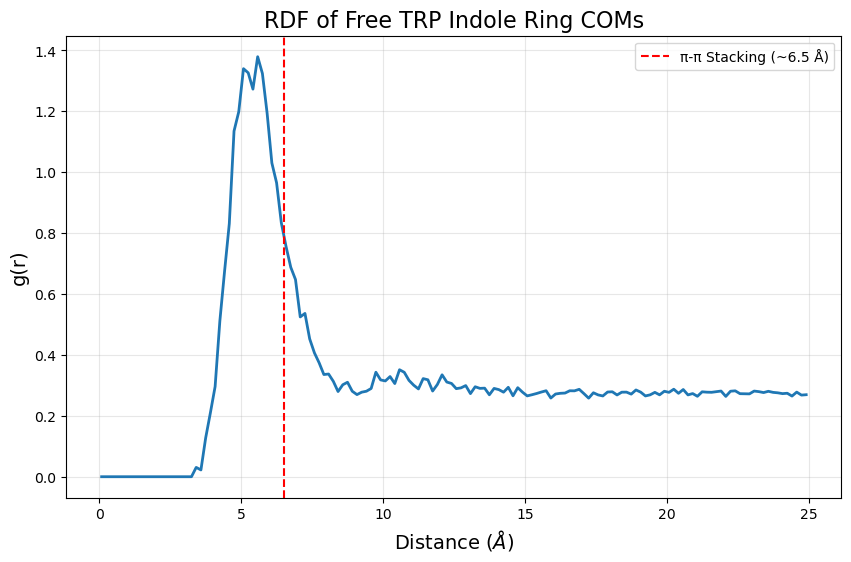

In [4]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array

# Load trajectory and topology
TPR = 'md_0_sim_resp_24trp-2ta_500ns.tpr'
XTC = 'md_0_sim_resp_24trp-2ta_500ns_pbc_center.xtc'
u = mda.Universe(TPR, XTC)

# Select TRP and TA5
trp = u.select_atoms("resname TRP")
ta = u.select_atoms("resname TA5")

# Function to compute COM of indole rings in TRP
def compute_ring_coms(trp):
    return np.array([
        trp.select_atoms(f"resid {res.resid} and name C1 N1 C2 C3 C4 C5 C6 C7 C8").center_of_mass()
        for res in trp.residues
    ])

# Distance between two centers of mass
def compute_distance(pos1, pos2, box_length):
    delta = pos1 - pos2
    delta -= np.round(delta / box_length) * box_length  # Apply PBC correction
    return np.linalg.norm(delta)

# Parameters
cutoff_1 = 15.0  # Cutoff distance to consider a TRP "free"
bins = 150
r_range = (0.0, 25.0)
bin_edges = np.linspace(r_range[0], r_range[1], bins + 1)
bin_centers_2ta = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_width = bin_edges[1] - bin_edges[0]

# Initialize histogram for RDF
hist = np.zeros(bins)
sum_1_over_V = 0.0

# Process trajectory
for ts in u.trajectory:
    # Compute TRP COMs
    trp_coms = compute_ring_coms(trp)
    
    # Compute TA COMs
    ta_coms = np.array([
        ta.atoms.select_atoms(f"resid {res.resid}").center_of_mass()
        for res in ta.residues
    ])

    # Find TRPs inside the cutoff distance
    inside_trps_idxs = []
    for ta_com in ta_coms:
        distances_to_ta = np.array([compute_distance(trp_com, ta_com, u.dimensions[:3]) for trp_com in trp_coms])
        inside_trps_idxs.append(np.where(distances_to_ta <= cutoff_1)[0])

    # Flatten and get unique TRPs within cutoff
    inside_trps_idxs = np.unique(np.concatenate(inside_trps_idxs)) if inside_trps_idxs else np.array([])

    # Identify free TRPs (those NOT inside the cutoff)
    free_trps = np.delete(np.arange(len(trp_coms)), inside_trps_idxs)

    # Skip if fewer than 2 free TRPs
    if len(free_trps) < 2:
        continue

    # Get coordinates of free TRPs
    free_trp_coms = trp_coms[free_trps]

    # Compute distances between free TRPs
    dist_matrix = distance_array(free_trp_coms, free_trp_coms, box=ts.dimensions)
    i, j = np.triu_indices(len(free_trp_coms), k=1)
    dist = dist_matrix[i, j]

    # Histogram binning
    current_hist, _ = np.histogram(dist, bins=bin_edges)
    hist += current_hist

    # Volume for normalization
    V = ts.volume
    sum_1_over_V += 1.0 / V

# Normalize RDF
N = len(trp.residues)  # Total TRPs
volume_shells = (4.0 / 3.0) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
expected = 0.5 * N * (N - 1) * volume_shells * sum_1_over_V
g_r_2ta = np.divide(hist, expected, out=np.zeros_like(hist), where=expected != 0)

# Plot RDF
plt.figure(figsize=(10, 6))
plt.plot(bin_centers_2ta, g_r_2ta, linewidth=2)
plt.xlabel(r'Distance ($\AA$)', fontsize=14)
plt.ylabel('g(r)', fontsize=14)
plt.title('RDF of Free TRP Indole Ring COMs', fontsize=16)
plt.axvline(6.5, linestyle="--", color="red", label="π-π Stacking (~6.5 Å)")
plt.legend()
plt.grid(True, alpha=0.3)
# plt.savefig('free_trp_rdf.png', dpi=300)
plt.show()


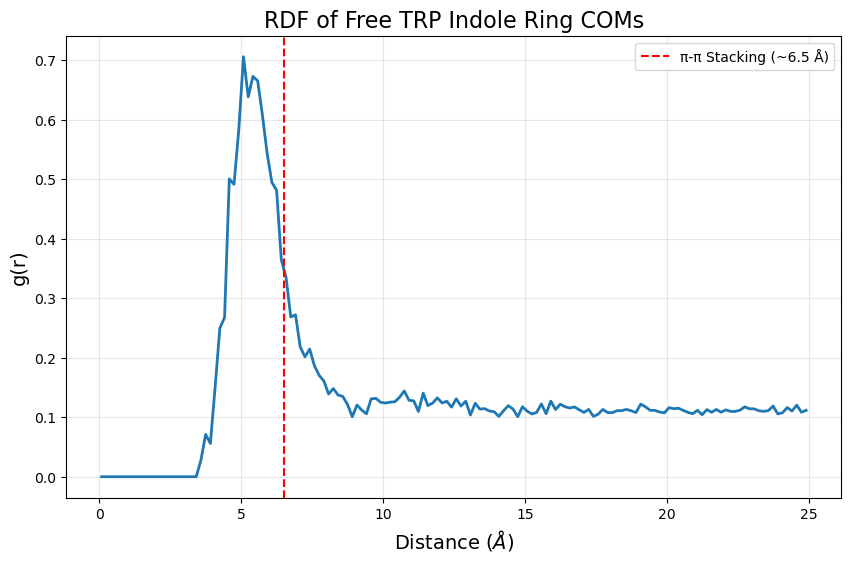

In [5]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array

# Load trajectory and topology
TPR = 'md_0_sim_resp_24trp-3ta_500ns.tpr'
XTC = 'md_0_sim_resp_24trp-3ta_500ns_pbc_center.xtc'
u = mda.Universe(TPR, XTC)

# Select TRP and TA5
trp = u.select_atoms("resname TRP")
ta = u.select_atoms("resname TA5")

# Function to compute COM of indole rings in TRP
def compute_ring_coms(trp):
    return np.array([
        trp.select_atoms(f"resid {res.resid} and name C1 N1 C2 C3 C4 C5 C6 C7 C8").center_of_mass()
        for res in trp.residues
    ])

# Distance between two centers of mass
def compute_distance(pos1, pos2, box_length):
    delta = pos1 - pos2
    delta -= np.round(delta / box_length) * box_length  # Apply PBC correction
    return np.linalg.norm(delta)

# Parameters
cutoff_1 = 15.0  # Cutoff distance to consider a TRP "free"
bins = 150
r_range = (0.0, 25.0)
bin_edges = np.linspace(r_range[0], r_range[1], bins + 1)
bin_centers_3ta = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_width = bin_edges[1] - bin_edges[0]

# Initialize histogram for RDF
hist = np.zeros(bins)
sum_1_over_V = 0.0

# Process trajectory
for ts in u.trajectory:
    # Compute TRP COMs
    trp_coms = compute_ring_coms(trp)
    
    # Compute TA COMs
    ta_coms = np.array([
        ta.atoms.select_atoms(f"resid {res.resid}").center_of_mass()
        for res in ta.residues
    ])

    # Find TRPs inside the cutoff distance
    inside_trps_idxs = []
    for ta_com in ta_coms:
        distances_to_ta = np.array([compute_distance(trp_com, ta_com, u.dimensions[:3]) for trp_com in trp_coms])
        inside_trps_idxs.append(np.where(distances_to_ta <= cutoff_1)[0])

    # Flatten and get unique TRPs within cutoff
    inside_trps_idxs = np.unique(np.concatenate(inside_trps_idxs)) if inside_trps_idxs else np.array([])

    # Identify free TRPs (those NOT inside the cutoff)
    free_trps = np.delete(np.arange(len(trp_coms)), inside_trps_idxs)

    # Skip if fewer than 2 free TRPs
    if len(free_trps) < 2:
        continue

    # Get coordinates of free TRPs
    free_trp_coms = trp_coms[free_trps]

    # Compute distances between free TRPs
    dist_matrix = distance_array(free_trp_coms, free_trp_coms, box=ts.dimensions)
    i, j = np.triu_indices(len(free_trp_coms), k=1)
    dist = dist_matrix[i, j]

    # Histogram binning
    current_hist, _ = np.histogram(dist, bins=bin_edges)
    hist += current_hist

    # Volume for normalization
    V = ts.volume
    sum_1_over_V += 1.0 / V

# Normalize RDF
N = len(trp.residues)  # Total TRPs
volume_shells = (4.0 / 3.0) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
expected = 0.5 * N * (N - 1) * volume_shells * sum_1_over_V
g_r_3ta = np.divide(hist, expected, out=np.zeros_like(hist), where=expected != 0)

# Plot RDF
plt.figure(figsize=(10, 6))
plt.plot(bin_centers_3ta, g_r_3ta, linewidth=2)
plt.xlabel(r'Distance ($\AA$)', fontsize=14)
plt.ylabel('g(r)', fontsize=14)
plt.title('RDF of Free TRP Indole Ring COMs', fontsize=16)
plt.axvline(6.5, linestyle="--", color="red", label="π-π Stacking (~6.5 Å)")
plt.legend()
plt.grid(True, alpha=0.3)
# plt.savefig('free_trp_rdf.png', dpi=300)
plt.show()


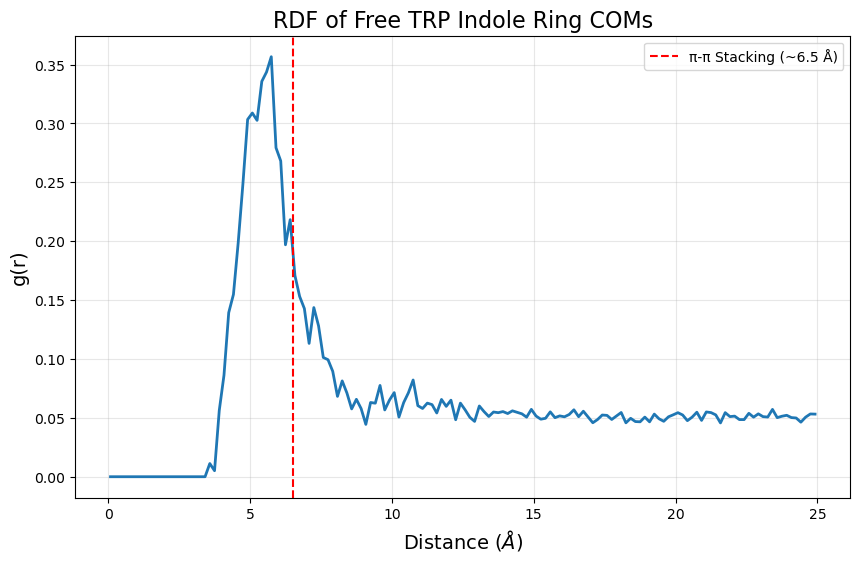

In [6]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array

# Load trajectory and topology
TPR = 'md_0_sim_resp_24trp-4ta_500ns.tpr'
XTC = 'md_0_sim_resp_24trp-4ta_500ns_pbc_center.xtc'
u = mda.Universe(TPR, XTC)

# Select TRP and TA5
trp = u.select_atoms("resname TRP")
ta = u.select_atoms("resname TA5")

# Function to compute COM of indole rings in TRP
def compute_ring_coms(trp):
    return np.array([
        trp.select_atoms(f"resid {res.resid} and name C1 N1 C2 C3 C4 C5 C6 C7 C8").center_of_mass()
        for res in trp.residues
    ])

# Distance between two centers of mass
def compute_distance(pos1, pos2, box_length):
    delta = pos1 - pos2
    delta -= np.round(delta / box_length) * box_length  # Apply PBC correction
    return np.linalg.norm(delta)

# Parameters
cutoff_1 = 15.0  # Cutoff distance to consider a TRP "free"
bins = 150
r_range = (0.0, 25.0)
bin_edges = np.linspace(r_range[0], r_range[1], bins + 1)
bin_centers_3ta = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_width = bin_edges[1] - bin_edges[0]

# Initialize histogram for RDF
hist = np.zeros(bins)
sum_1_over_V = 0.0

# Process trajectory
for ts in u.trajectory:
    # Compute TRP COMs
    trp_coms = compute_ring_coms(trp)
    
    # Compute TA COMs
    ta_coms = np.array([
        ta.atoms.select_atoms(f"resid {res.resid}").center_of_mass()
        for res in ta.residues
    ])

    # Find TRPs inside the cutoff distance
    inside_trps_idxs = []
    for ta_com in ta_coms:
        distances_to_ta = np.array([compute_distance(trp_com, ta_com, u.dimensions[:3]) for trp_com in trp_coms])
        inside_trps_idxs.append(np.where(distances_to_ta <= cutoff_1)[0])

    # Flatten and get unique TRPs within cutoff
    inside_trps_idxs = np.unique(np.concatenate(inside_trps_idxs)) if inside_trps_idxs else np.array([])

    # Identify free TRPs (those NOT inside the cutoff)
    free_trps = np.delete(np.arange(len(trp_coms)), inside_trps_idxs)

    # Skip if fewer than 2 free TRPs
    if len(free_trps) < 2:
        continue

    # Get coordinates of free TRPs
    free_trp_coms = trp_coms[free_trps]

    # Compute distances between free TRPs
    dist_matrix = distance_array(free_trp_coms, free_trp_coms, box=ts.dimensions)
    i, j = np.triu_indices(len(free_trp_coms), k=1)
    dist = dist_matrix[i, j]

    # Histogram binning
    current_hist, _ = np.histogram(dist, bins=bin_edges)
    hist += current_hist

    # Volume for normalization
    V = ts.volume
    sum_1_over_V += 1.0 / V

# Normalize RDF
N = len(trp.residues)  # Total TRPs
volume_shells = (4.0 / 3.0) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
expected = 0.5 * N * (N - 1) * volume_shells * sum_1_over_V
g_r_3ta = np.divide(hist, expected, out=np.zeros_like(hist), where=expected != 0)

# Plot RDF
plt.figure(figsize=(10, 6))
plt.plot(bin_centers_3ta, g_r_3ta, linewidth=2)
plt.xlabel(r'Distance ($\AA$)', fontsize=14)
plt.ylabel('g(r)', fontsize=14)
plt.title('RDF of Free TRP Indole Ring COMs', fontsize=16)
plt.axvline(6.5, linestyle="--", color="red", label="π-π Stacking (~6.5 Å)")
plt.legend()
plt.grid(True, alpha=0.3)
# plt.savefig('free_trp_rdf.png', dpi=300)
plt.show()


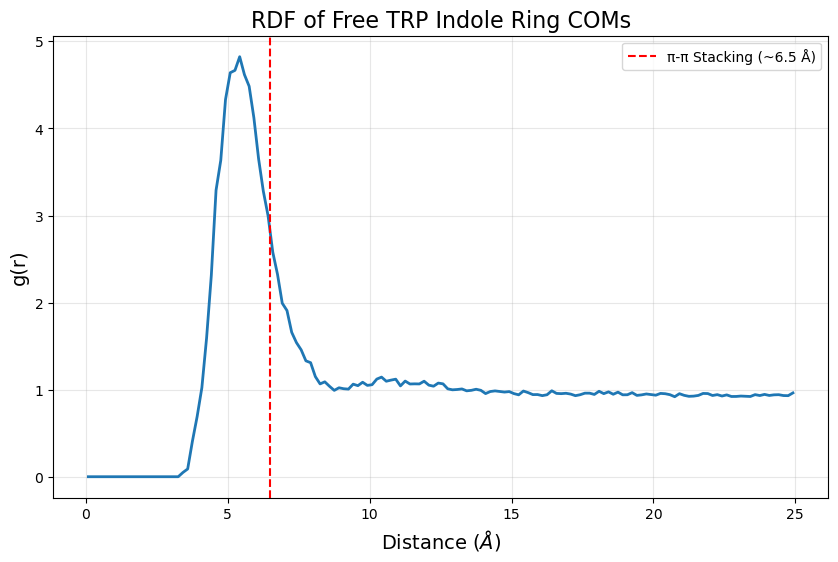

In [7]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array

# Load trajectory and topology
TPR = 'md_0_sim_resp_24trp-1sbt_500ns.tpr'
XTC = 'md_0_sim_resp_24trp-1sbt_500ns_pbc_center.xtc'
u = mda.Universe(TPR, XTC)

# Select TRP and TA5
trp = u.select_atoms("resname TRP")
ta = u.select_atoms("resname SBT")

# Function to compute COM of indole rings in TRP
def compute_ring_coms(trp):
    return np.array([
        trp.select_atoms(f"resid {res.resid} and name C1 N1 C2 C3 C4 C5 C6 C7 C8").center_of_mass()
        for res in trp.residues
    ])

# Distance between two centers of mass
def compute_distance(pos1, pos2, box_length):
    delta = pos1 - pos2
    delta -= np.round(delta / box_length) * box_length  # Apply PBC correction
    return np.linalg.norm(delta)

# Parameters
cutoff_1 = 12.0  # Cutoff distance to consider a TRP "free"
bins = 150
r_range = (0.0, 25.0)
bin_edges = np.linspace(r_range[0], r_range[1], bins + 1)
bin_centers2 = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_width = bin_edges[1] - bin_edges[0]

# Initialize histogram for RDF
hist = np.zeros(bins)
sum_1_over_V = 0.0

# Process trajectory
for ts in u.trajectory:
    # Compute TRP COMs
    trp_coms = compute_ring_coms(trp)
    
    # Compute TA COMs
    ta_coms = np.array([
        ta.atoms.select_atoms(f"resid {res.resid}").center_of_mass()
        for res in ta.residues
    ])

    # Find TRPs inside the cutoff distance
    inside_trps_idxs = []
    for ta_com in ta_coms:
        distances_to_ta = np.array([compute_distance(trp_com, ta_com, u.dimensions[:3]) for trp_com in trp_coms])
        inside_trps_idxs.append(np.where(distances_to_ta <= cutoff_1)[0])

    # Flatten and get unique TRPs within cutoff
    inside_trps_idxs = np.unique(np.concatenate(inside_trps_idxs)) if inside_trps_idxs else np.array([])

    # Identify free TRPs (those NOT inside the cutoff)
    free_trps = np.delete(np.arange(len(trp_coms)), inside_trps_idxs)

    # Skip if fewer than 2 free TRPs
    if len(free_trps) < 2:
        continue

    # Get coordinates of free TRPs
    free_trp_coms = trp_coms[free_trps]

    # Compute distances between free TRPs
    dist_matrix = distance_array(free_trp_coms, free_trp_coms, box=ts.dimensions)
    i, j = np.triu_indices(len(free_trp_coms), k=1)
    dist = dist_matrix[i, j]

    # Histogram binning
    current_hist, _ = np.histogram(dist, bins=bin_edges)
    hist += current_hist

    # Volume for normalization
    V = ts.volume
    sum_1_over_V += 1.0 / V

# Normalize RDF
N = len(trp.residues)  # Total TRPs
volume_shells = (4.0 / 3.0) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
expected = 0.5 * N * (N - 1) * volume_shells * sum_1_over_V
g_r2 = np.divide(hist, expected, out=np.zeros_like(hist), where=expected != 0)

# Plot RDF
plt.figure(figsize=(10, 6))
plt.plot(bin_centers2, g_r2, linewidth=2)
plt.xlabel(r'Distance ($\AA$)', fontsize=14)
plt.ylabel('g(r)', fontsize=14)
plt.title('RDF of Free TRP Indole Ring COMs', fontsize=16)
plt.axvline(6.5, linestyle="--", color="red", label="π-π Stacking (~6.5 Å)")
plt.legend()
plt.grid(True, alpha=0.3)
# plt.savefig('free_trp_rdf.png', dpi=300)
plt.show()


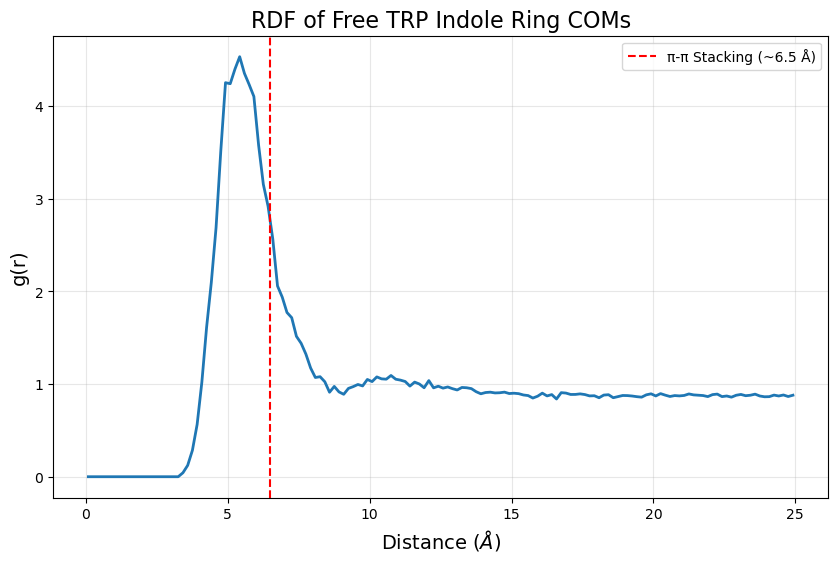

In [8]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array

# Load trajectory and topology
TPR = 'md_0_sim_resp_24trp-2sbt_500ns.tpr'
XTC = 'md_0_sim_resp_24trp-2sbt_500ns_pbc_center.xtc'
u = mda.Universe(TPR, XTC)

# Select TRP and TA5
trp = u.select_atoms("resname TRP")
ta = u.select_atoms("resname SBT")

# Function to compute COM of indole rings in TRP
def compute_ring_coms(trp):
    return np.array([
        trp.select_atoms(f"resid {res.resid} and name C1 N1 C2 C3 C4 C5 C6 C7 C8").center_of_mass()
        for res in trp.residues
    ])

# Distance between two centers of mass
def compute_distance(pos1, pos2, box_length):
    delta = pos1 - pos2
    delta -= np.round(delta / box_length) * box_length  # Apply PBC correction
    return np.linalg.norm(delta)

# Parameters
cutoff_1 = 12.0  # Cutoff distance to consider a TRP "free"
bins = 150
r_range = (0.0, 25.0)
bin_edges = np.linspace(r_range[0], r_range[1], bins + 1)
bin_centers4 = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_width = bin_edges[1] - bin_edges[0]

# Initialize histogram for RDF
hist = np.zeros(bins)
sum_1_over_V = 0.0

# Process trajectory
for ts in u.trajectory:
    # Compute TRP COMs
    trp_coms = compute_ring_coms(trp)
    
    # Compute TA COMs
    ta_coms = np.array([
        ta.atoms.select_atoms(f"resid {res.resid}").center_of_mass()
        for res in ta.residues
    ])

    # Find TRPs inside the cutoff distance
    inside_trps_idxs = []
    for ta_com in ta_coms:
        distances_to_ta = np.array([compute_distance(trp_com, ta_com, u.dimensions[:3]) for trp_com in trp_coms])
        inside_trps_idxs.append(np.where(distances_to_ta <= cutoff_1)[0])

    # Flatten and get unique TRPs within cutoff
    inside_trps_idxs = np.unique(np.concatenate(inside_trps_idxs)) if inside_trps_idxs else np.array([])

    # Identify free TRPs (those NOT inside the cutoff)
    free_trps = np.delete(np.arange(len(trp_coms)), inside_trps_idxs)

    # Skip if fewer than 2 free TRPs
    if len(free_trps) < 2:
        continue

    # Get coordinates of free TRPs
    free_trp_coms = trp_coms[free_trps]

    # Compute distances between free TRPs
    dist_matrix = distance_array(free_trp_coms, free_trp_coms, box=ts.dimensions)
    i, j = np.triu_indices(len(free_trp_coms), k=1)
    dist = dist_matrix[i, j]

    # Histogram binning
    current_hist, _ = np.histogram(dist, bins=bin_edges)
    hist += current_hist

    # Volume for normalization
    V = ts.volume
    sum_1_over_V += 1.0 / V

# Normalize RDF
N = len(trp.residues)  # Total TRPs
volume_shells = (4.0 / 3.0) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
expected = 0.5 * N * (N - 1) * volume_shells * sum_1_over_V
g_r4 = np.divide(hist, expected, out=np.zeros_like(hist), where=expected != 0)

# Plot RDF
plt.figure(figsize=(10, 6))
plt.plot(bin_centers4, g_r4, linewidth=2)
plt.xlabel(r'Distance ($\AA$)', fontsize=14)
plt.ylabel('g(r)', fontsize=14)
plt.title('RDF of Free TRP Indole Ring COMs', fontsize=16)
plt.axvline(6.5, linestyle="--", color="red", label="π-π Stacking (~6.5 Å)")
plt.legend()
plt.grid(True, alpha=0.3)
# plt.savefig('free_trp_rdf.png', dpi=300)
plt.show()


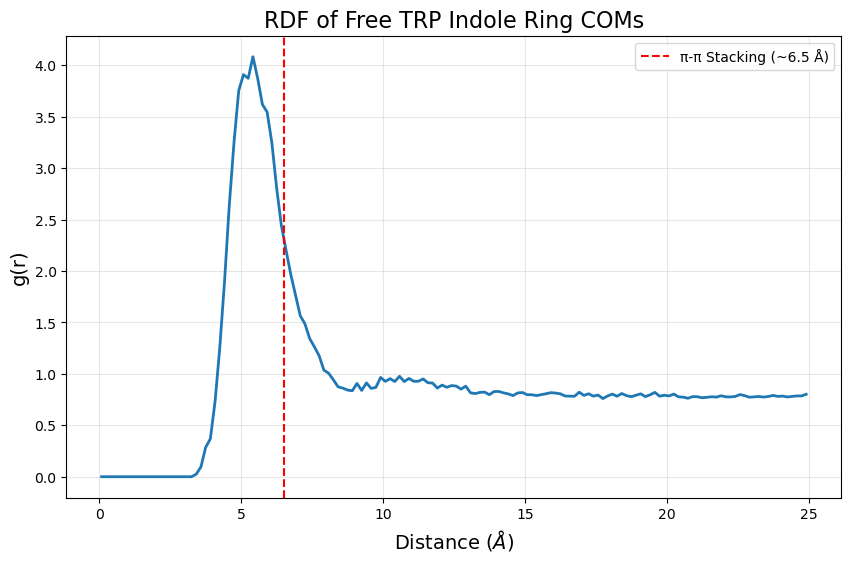

In [9]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array

# Load trajectory and topology
TPR = 'md_0_sim_resp_24trp-4sbt_500ns.tpr'
XTC = 'md_0_sim_resp_24trp-4sbt_500ns_pbc_center.xtc'
u = mda.Universe(TPR, XTC)

# Select TRP and TA5
trp = u.select_atoms("resname TRP")
ta = u.select_atoms("resname SBT")

# Function to compute COM of indole rings in TRP
def compute_ring_coms(trp):
    return np.array([
        trp.select_atoms(f"resid {res.resid} and name C1 N1 C2 C3 C4 C5 C6 C7 C8").center_of_mass()
        for res in trp.residues
    ])

# Distance between two centers of mass
def compute_distance(pos1, pos2, box_length):
    delta = pos1 - pos2
    delta -= np.round(delta / box_length) * box_length  # Apply PBC correction
    return np.linalg.norm(delta)

# Parameters
cutoff_1 = 12.0  # Cutoff distance to consider a TRP "free"
bins = 150
r_range = (0.0, 25.0)
bin_edges = np.linspace(r_range[0], r_range[1], bins + 1)
bin_centers6 = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_width = bin_edges[1] - bin_edges[0]

# Initialize histogram for RDF
hist = np.zeros(bins)
sum_1_over_V = 0.0

# Process trajectory
for ts in u.trajectory:
    # Compute TRP COMs
    trp_coms = compute_ring_coms(trp)
    
    # Compute TA COMs
    ta_coms = np.array([
        ta.atoms.select_atoms(f"resid {res.resid}").center_of_mass()
        for res in ta.residues
    ])

    # Find TRPs inside the cutoff distance
    inside_trps_idxs = []
    for ta_com in ta_coms:
        distances_to_ta = np.array([compute_distance(trp_com, ta_com, u.dimensions[:3]) for trp_com in trp_coms])
        inside_trps_idxs.append(np.where(distances_to_ta <= cutoff_1)[0])

    # Flatten and get unique TRPs within cutoff
    inside_trps_idxs = np.unique(np.concatenate(inside_trps_idxs)) if inside_trps_idxs else np.array([])

    # Identify free TRPs (those NOT inside the cutoff)
    free_trps = np.delete(np.arange(len(trp_coms)), inside_trps_idxs)

    # Skip if fewer than 2 free TRPs
    if len(free_trps) < 2:
        continue

    # Get coordinates of free TRPs
    free_trp_coms = trp_coms[free_trps]

    # Compute distances between free TRPs
    dist_matrix = distance_array(free_trp_coms, free_trp_coms, box=ts.dimensions)
    i, j = np.triu_indices(len(free_trp_coms), k=1)
    dist = dist_matrix[i, j]

    # Histogram binning
    current_hist, _ = np.histogram(dist, bins=bin_edges)
    hist += current_hist

    # Volume for normalization
    V = ts.volume
    sum_1_over_V += 1.0 / V

# Normalize RDF
N = len(trp.residues)  # Total TRPs
volume_shells = (4.0 / 3.0) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
expected = 0.5 * N * (N - 1) * volume_shells * sum_1_over_V
g_r6 = np.divide(hist, expected, out=np.zeros_like(hist), where=expected != 0)

# Plot RDF
plt.figure(figsize=(10, 6))
plt.plot(bin_centers6, g_r6, linewidth=2)
plt.xlabel(r'Distance ($\AA$)', fontsize=14)
plt.ylabel('g(r)', fontsize=14)
plt.title('RDF of Free TRP Indole Ring COMs', fontsize=16)
plt.axvline(6.5, linestyle="--", color="red", label="π-π Stacking (~6.5 Å)")
plt.legend()
plt.grid(True, alpha=0.3)
# plt.savefig('free_trp_rdf.png', dpi=300)
plt.show()


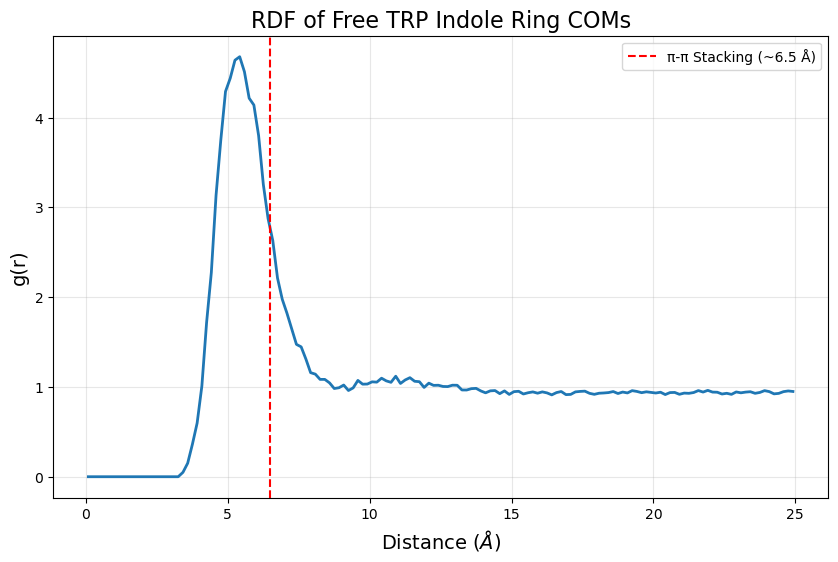

In [10]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array

# Load trajectory and topology
TPR = 'md_0_sim_resp_24trp-1mnt_500ns.tpr'
XTC = 'md_0_sim_resp_24trp-1mnt_500ns_pbc_center.xtc'
u = mda.Universe(TPR, XTC)

# Select TRP and TA5
trp = u.select_atoms("resname TRP")
ta = u.select_atoms("resname MNT")

# Function to compute COM of indole rings in TRP
def compute_ring_coms(trp):
    return np.array([
        trp.select_atoms(f"resid {res.resid} and name C1 N1 C2 C3 C4 C5 C6 C7 C8").center_of_mass()
        for res in trp.residues
    ])

# Distance between two centers of mass
def compute_distance(pos1, pos2, box_length):
    delta = pos1 - pos2
    delta -= np.round(delta / box_length) * box_length  # Apply PBC correction
    return np.linalg.norm(delta)

# Parameters
cutoff_1 = 12.0  # Cutoff distance to consider a TRP "free"
bins = 150
r_range = (0.0, 25.0)
bin_edges = np.linspace(r_range[0], r_range[1], bins + 1)
bin_centers3 = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_width = bin_edges[1] - bin_edges[0]

# Initialize histogram for RDF
hist = np.zeros(bins)
sum_1_over_V = 0.0

# Process trajectory
for ts in u.trajectory:
    # Compute TRP COMs
    trp_coms = compute_ring_coms(trp)
    
    # Compute TA COMs
    ta_coms = np.array([
        ta.atoms.select_atoms(f"resid {res.resid}").center_of_mass()
        for res in ta.residues
    ])

    # Find TRPs inside the cutoff distance
    inside_trps_idxs = []
    for ta_com in ta_coms:
        distances_to_ta = np.array([compute_distance(trp_com, ta_com, u.dimensions[:3]) for trp_com in trp_coms])
        inside_trps_idxs.append(np.where(distances_to_ta <= cutoff_1)[0])

    # Flatten and get unique TRPs within cutoff
    inside_trps_idxs = np.unique(np.concatenate(inside_trps_idxs)) if inside_trps_idxs else np.array([])

    # Identify free TRPs (those NOT inside the cutoff)
    free_trps = np.delete(np.arange(len(trp_coms)), inside_trps_idxs)

    # Skip if fewer than 2 free TRPs
    if len(free_trps) < 2:
        continue

    # Get coordinates of free TRPs
    free_trp_coms = trp_coms[free_trps]

    # Compute distances between free TRPs
    dist_matrix = distance_array(free_trp_coms, free_trp_coms, box=ts.dimensions)
    i, j = np.triu_indices(len(free_trp_coms), k=1)
    dist = dist_matrix[i, j]

    # Histogram binning
    current_hist, _ = np.histogram(dist, bins=bin_edges)
    hist += current_hist

    # Volume for normalization
    V = ts.volume
    sum_1_over_V += 1.0 / V

# Normalize RDF
N = len(trp.residues)  # Total TRPs
volume_shells = (4.0 / 3.0) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
expected = 0.5 * N * (N - 1) * volume_shells * sum_1_over_V
g_r3 = np.divide(hist, expected, out=np.zeros_like(hist), where=expected != 0)

# Plot RDF
plt.figure(figsize=(10, 6))
plt.plot(bin_centers3, g_r3, linewidth=2)
plt.xlabel(r'Distance ($\AA$)', fontsize=14)
plt.ylabel('g(r)', fontsize=14)
plt.title('RDF of Free TRP Indole Ring COMs', fontsize=16)
plt.axvline(6.5, linestyle="--", color="red", label="π-π Stacking (~6.5 Å)")
plt.legend()
plt.grid(True, alpha=0.3)
# plt.savefig('free_trp_rdf.png', dpi=300)
plt.show()


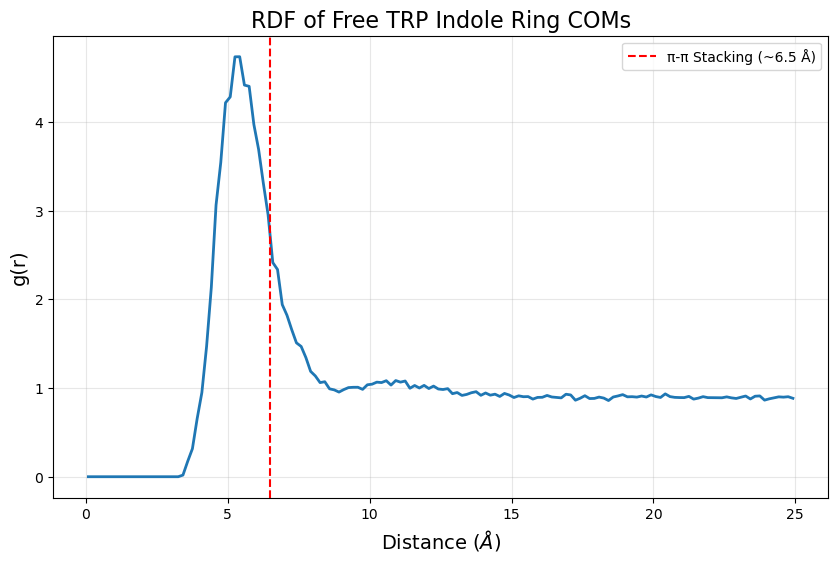

In [11]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array

# Load trajectory and topology
TPR = 'md_0_sim_resp_24trp-2mnt_500ns.tpr'
XTC = 'md_0_sim_resp_24trp-2mnt_500ns_pbc_center.xtc'
u = mda.Universe(TPR, XTC)

# Select TRP and TA5
trp = u.select_atoms("resname TRP")
ta = u.select_atoms("resname MNT")

# Function to compute COM of indole rings in TRP
def compute_ring_coms(trp):
    return np.array([
        trp.select_atoms(f"resid {res.resid} and name C1 N1 C2 C3 C4 C5 C6 C7 C8").center_of_mass()
        for res in trp.residues
    ])

# Distance between two centers of mass
def compute_distance(pos1, pos2, box_length):
    delta = pos1 - pos2
    delta -= np.round(delta / box_length) * box_length  # Apply PBC correction
    return np.linalg.norm(delta)

# Parameters
cutoff_1 = 12.0  # Cutoff distance to consider a TRP "free"
bins = 150
r_range = (0.0, 25.0)
bin_edges = np.linspace(r_range[0], r_range[1], bins + 1)
bin_centers5 = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_width = bin_edges[1] - bin_edges[0]

# Initialize histogram for RDF
hist = np.zeros(bins)
sum_1_over_V = 0.0

# Process trajectory
for ts in u.trajectory:
    # Compute TRP COMs
    trp_coms = compute_ring_coms(trp)
    
    # Compute TA COMs
    ta_coms = np.array([
        ta.atoms.select_atoms(f"resid {res.resid}").center_of_mass()
        for res in ta.residues
    ])

    # Find TRPs inside the cutoff distance
    inside_trps_idxs = []
    for ta_com in ta_coms:
        distances_to_ta = np.array([compute_distance(trp_com, ta_com, u.dimensions[:3]) for trp_com in trp_coms])
        inside_trps_idxs.append(np.where(distances_to_ta <= cutoff_1)[0])

    # Flatten and get unique TRPs within cutoff
    inside_trps_idxs = np.unique(np.concatenate(inside_trps_idxs)) if inside_trps_idxs else np.array([])

    # Identify free TRPs (those NOT inside the cutoff)
    free_trps = np.delete(np.arange(len(trp_coms)), inside_trps_idxs)

    # Skip if fewer than 2 free TRPs
    if len(free_trps) < 2:
        continue

    # Get coordinates of free TRPs
    free_trp_coms = trp_coms[free_trps]

    # Compute distances between free TRPs
    dist_matrix = distance_array(free_trp_coms, free_trp_coms, box=ts.dimensions)
    i, j = np.triu_indices(len(free_trp_coms), k=1)
    dist = dist_matrix[i, j]

    # Histogram binning
    current_hist, _ = np.histogram(dist, bins=bin_edges)
    hist += current_hist

    # Volume for normalization
    V = ts.volume
    sum_1_over_V += 1.0 / V

# Normalize RDF
N = len(trp.residues)  # Total TRPs
volume_shells = (4.0 / 3.0) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
expected = 0.5 * N * (N - 1) * volume_shells * sum_1_over_V
g_r5 = np.divide(hist, expected, out=np.zeros_like(hist), where=expected != 0)

# Plot RDF
plt.figure(figsize=(10, 6))
plt.plot(bin_centers5, g_r5, linewidth=2)
plt.xlabel(r'Distance ($\AA$)', fontsize=14)
plt.ylabel('g(r)', fontsize=14)
plt.title('RDF of Free TRP Indole Ring COMs', fontsize=16)
plt.axvline(6.5, linestyle="--", color="red", label="π-π Stacking (~6.5 Å)")
plt.legend()
plt.grid(True, alpha=0.3)
# plt.savefig('free_trp_rdf.png', dpi=300)
plt.show()


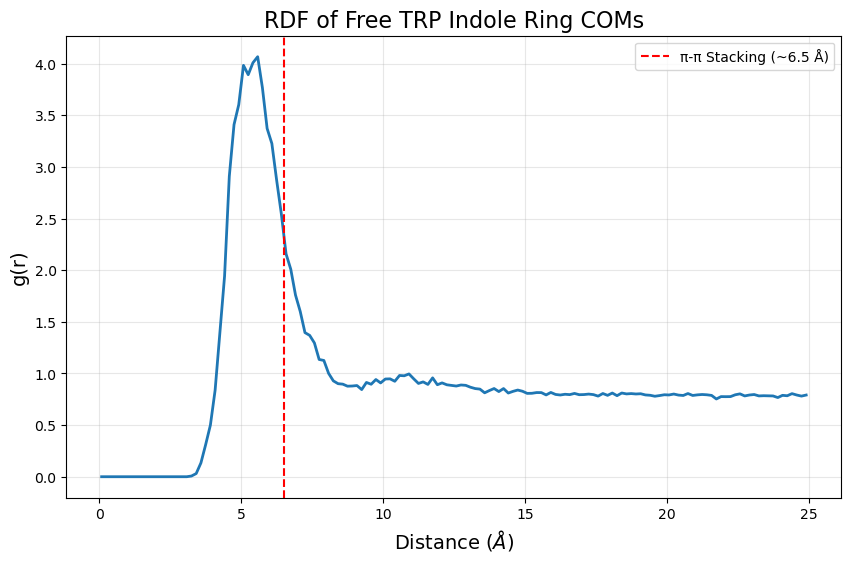

In [12]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array

# Load trajectory and topology
TPR = 'md_0_sim_resp_24trp-4mnt_500ns.tpr'
XTC = 'md_0_sim_resp_24trp-4mnt_500ns_pbc_center.xtc'
u = mda.Universe(TPR, XTC)

# Select TRP and TA5
trp = u.select_atoms("resname TRP")
ta = u.select_atoms("resname MNT")

# Function to compute COM of indole rings in TRP
def compute_ring_coms(trp):
    return np.array([
        trp.select_atoms(f"resid {res.resid} and name C1 N1 C2 C3 C4 C5 C6 C7 C8").center_of_mass()
        for res in trp.residues
    ])

# Distance between two centers of mass
def compute_distance(pos1, pos2, box_length):
    delta = pos1 - pos2
    delta -= np.round(delta / box_length) * box_length  # Apply PBC correction
    return np.linalg.norm(delta)

# Parameters
cutoff_1 = 12.0  # Cutoff distance to consider a TRP "free"
bins = 150
r_range = (0.0, 25.0)
bin_edges = np.linspace(r_range[0], r_range[1], bins + 1)
bin_centers7 = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_width = bin_edges[1] - bin_edges[0]

# Initialize histogram for RDF
hist = np.zeros(bins)
sum_1_over_V = 0.0

# Process trajectory
for ts in u.trajectory:
    # Compute TRP COMs
    trp_coms = compute_ring_coms(trp)
    
    # Compute TA COMs
    ta_coms = np.array([
        ta.atoms.select_atoms(f"resid {res.resid}").center_of_mass()
        for res in ta.residues
    ])

    # Find TRPs inside the cutoff distance
    inside_trps_idxs = []
    for ta_com in ta_coms:
        distances_to_ta = np.array([compute_distance(trp_com, ta_com, u.dimensions[:3]) for trp_com in trp_coms])
        inside_trps_idxs.append(np.where(distances_to_ta <= cutoff_1)[0])

    # Flatten and get unique TRPs within cutoff
    inside_trps_idxs = np.unique(np.concatenate(inside_trps_idxs)) if inside_trps_idxs else np.array([])

    # Identify free TRPs (those NOT inside the cutoff)
    free_trps = np.delete(np.arange(len(trp_coms)), inside_trps_idxs)

    # Skip if fewer than 2 free TRPs
    if len(free_trps) < 2:
        continue

    # Get coordinates of free TRPs
    free_trp_coms = trp_coms[free_trps]

    # Compute distances between free TRPs
    dist_matrix = distance_array(free_trp_coms, free_trp_coms, box=ts.dimensions)
    i, j = np.triu_indices(len(free_trp_coms), k=1)
    dist = dist_matrix[i, j]

    # Histogram binning
    current_hist, _ = np.histogram(dist, bins=bin_edges)
    hist += current_hist

    # Volume for normalization
    V = ts.volume
    sum_1_over_V += 1.0 / V

# Normalize RDF
N = len(trp.residues)  # Total TRPs
volume_shells = (4.0 / 3.0) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
expected = 0.5 * N * (N - 1) * volume_shells * sum_1_over_V
g_r7 = np.divide(hist, expected, out=np.zeros_like(hist), where=expected != 0)

# Plot RDF
plt.figure(figsize=(10, 6))
plt.plot(bin_centers7, g_r7, linewidth=2)
plt.xlabel(r'Distance ($\AA$)', fontsize=14)
plt.ylabel('g(r)', fontsize=14)
plt.title('RDF of Free TRP Indole Ring COMs', fontsize=16)
plt.axvline(6.5, linestyle="--", color="red", label="π-π Stacking (~6.5 Å)")
plt.legend()
plt.grid(True, alpha=0.3)
# plt.savefig('free_trp_rdf.png', dpi=300)
plt.show()


/var/folders/jc/r1qz74_n1_9613zrlx8dzt4r0000gn/T/ipykernel_13174/1246174576.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


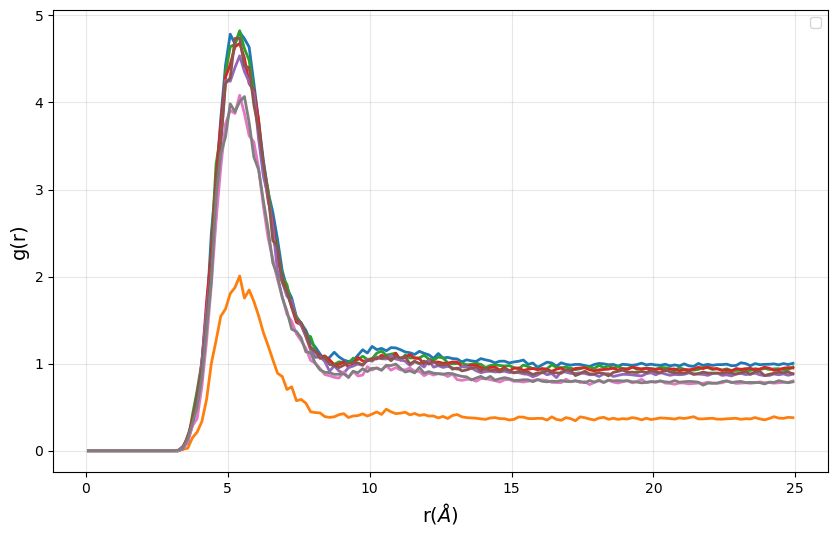

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(r, g_r, linewidth=2)
plt.plot(bin_centers1, g_r1, linewidth=2)
plt.plot(bin_centers2, g_r2, linewidth=2)
plt.plot(bin_centers3, g_r3, linewidth=2)
plt.plot(bin_centers4, g_r4, linewidth=2)
plt.plot(bin_centers5, g_r5, linewidth=2)
plt.plot(bin_centers6, g_r6, linewidth=2)
plt.plot(bin_centers7, g_r7, linewidth=2)

plt.xlabel(r'r($\AA$)', fontsize=14)
plt.ylabel('g(r)', fontsize=14)
# plt.title('RDF of Free TRP Indole Ring COMs', fontsize=16)
# plt.axvline(6.5, linestyle="--", color="red", label="π-π Stacking (~6.5 Å)")
plt.legend()
plt.grid(True, alpha=0.3)
# plt.savefig('free_trp_rdf.png', dpi=300)
plt.show()

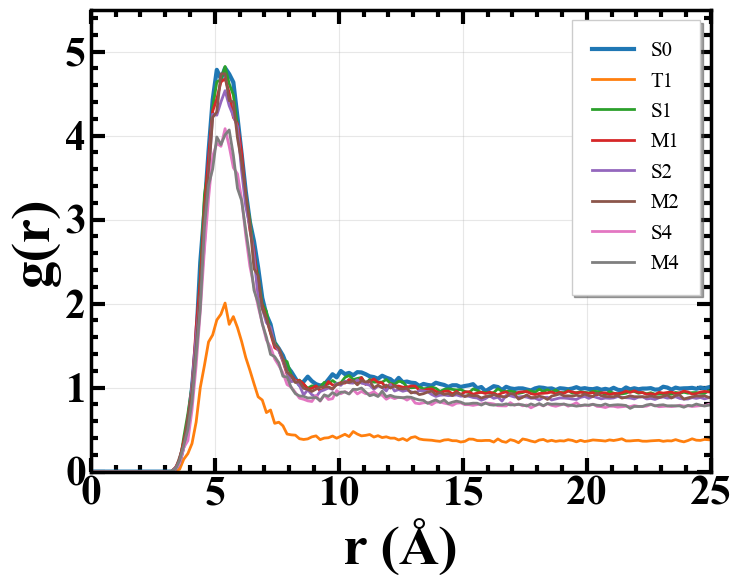

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

# Set publication-quality plotting parameters
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 35,
    "axes.labelsize": 30,
    "axes.titlesize": 20,
    "axes.labelweight": 'bold',
    "axes.linewidth": 2.5,
    "lines.linewidth": 3.5,
    "xtick.labelsize": 25,
    "ytick.labelsize": 25,
    "xtick.direction": 'in',
    "ytick.direction": 'in',
    "xtick.top": True,
    "xtick.bottom": True,
    "ytick.right": True,
    "xtick.major.size": 10,
    "ytick.major.size": 10,
    "xtick.major.width": 3,
    "ytick.major.width": 3,
    "xtick.minor.size": 5,
    "ytick.minor.size": 5,
    "xtick.minor.width": 3,
    "ytick.minor.width": 3,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "legend.fontsize": 15,
    "legend.frameon": True,
    "legend.loc": 'upper right',
    "legend.markerscale": 1.5,
    "legend.borderpad": 1.0,
    "savefig.dpi": 500,
    "savefig.bbox": 'tight',
})



# Plotting
plt.figure(figsize=(8, 6))
plt.plot(r, g_r, label='S0', linewidth=3)
plt.plot(bin_centers1, g_r1, label='T1', linewidth=2)
plt.plot(bin_centers2, g_r2, label='S1', linewidth=2)
plt.plot(bin_centers3, g_r3, label='M1', linewidth=2)
plt.plot(bin_centers4, g_r4, label='S2', linewidth=2)
plt.plot(bin_centers5, g_r5, label='M2', linewidth=2)
plt.plot(bin_centers6, g_r6, label='S4', linewidth=2)
plt.plot(bin_centers7, g_r7, label='M4', linewidth=2)

# Labels and formatting
# plt.xlabel(r'$r$ ($\AA$)', fontsize=30)
# plt.ylabel(r'$g(r)$', fontsize=30)
plt.xlabel(r'r (Å)', fontsize=40)
plt.ylabel('g(r)', fontsize=40)
plt.xticks(fontsize=30, fontweight= 'bold')
plt.yticks(fontsize=30,  fontweight= 'bold')
plt.legend(ncol=1, fontsize=14, frameon=True, fancybox=False, shadow=True, loc='upper right', prop={'weight': 'normal'})
plt.grid(True, alpha=0.3)
plt.xlim(0, 25)
plt.ylim(0, 5.5)
plt.savefig('indole_ring_com_rdf.png', dpi=500, bbox_inches="tight")
plt.show()


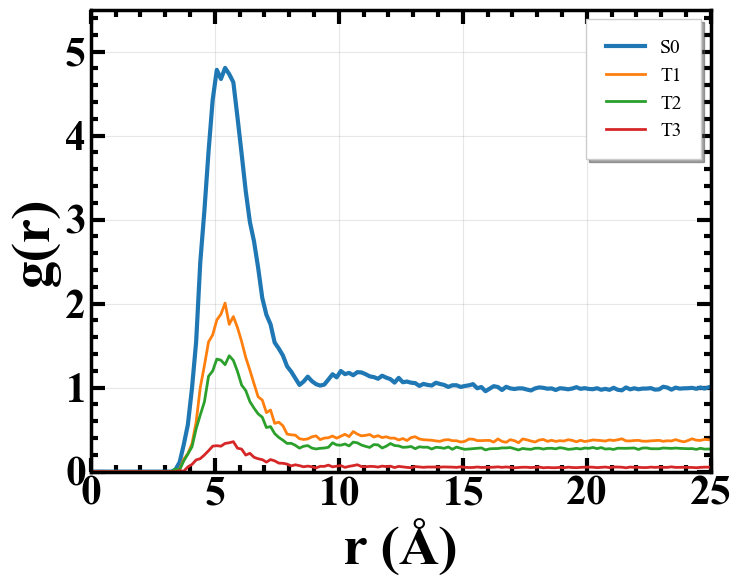

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

# Set publication-quality plotting parameters
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 35,
    "axes.labelsize": 30,
    "axes.titlesize": 20,
    "axes.labelweight": 'bold',
    "axes.linewidth": 2.5,
    "lines.linewidth": 3.5,
    "xtick.labelsize": 25,
    "ytick.labelsize": 25,
    "xtick.direction": 'in',
    "ytick.direction": 'in',
    "xtick.top": True,
    "xtick.bottom": True,
    "ytick.right": True,
    "xtick.major.size": 10,
    "ytick.major.size": 10,
    "xtick.major.width": 3,
    "ytick.major.width": 3,
    "xtick.minor.size": 5,
    "ytick.minor.size": 5,
    "xtick.minor.width": 3,
    "ytick.minor.width": 3,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "legend.fontsize": 14,
    "legend.frameon": True,
    "legend.loc": 'upper right',
    "legend.markerscale": 1.5,
    "legend.borderpad": 1.0,
    "savefig.dpi": 500,
    "savefig.bbox": 'tight',
})



# Plotting
plt.figure(figsize=(8, 6))
plt.plot(r, g_r, label='S0', linewidth=3)
plt.plot(bin_centers1, g_r1, label='T1', linewidth=2)
plt.plot(bin_centers_2ta, g_r_2ta, label='T2', linewidth=2)
plt.plot(bin_centers_3ta, g_r_3ta, label='T3', linewidth=2)


# Labels and formatting

plt.xlabel(r'r (Å)', fontsize=40)
plt.ylabel('g(r)', fontsize=40)
plt.xticks(fontsize=30, fontweight= 'bold')
plt.yticks(fontsize=30,  fontweight= 'bold')
plt.legend(ncol=1, fontsize=14, frameon=True, fancybox=False, shadow=True, loc='upper right', prop={'weight': 'normal'})
plt.grid(True, alpha=0.3)
plt.xlim(0, 25)
plt.ylim(0, 5.5)
plt.savefig('indole_ring_com_rdf_ta1.png', dpi=500, bbox_inches="tight")
plt.show()
